чтение последних строк тренировочных данных
         Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
9995    77          32    2.0  50.401785   30.476203            5.0      6   
9996  6159          18    1.0  41.521546   20.539216            9.0     13   
9997  5123          27    1.0  47.939008         NaN            1.0     12   
9998  5400          75    2.0  43.602562   33.840147            8.0      1   
9999  6306         128    1.0  38.666645   21.157874            8.0      7   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
9995         5.0       1968   0.135650         B         B        46   
9996        13.0       2000   0.000000         B         B        30   
9997        16.0       2015   0.072158         B         B         2   
9998         5.0       1961   0.307467         B         A        30   
9999        17.0       1990   0.000000         B         B        27   

      Social_2  Social_3  Healthcare_1  Helthcare_2  

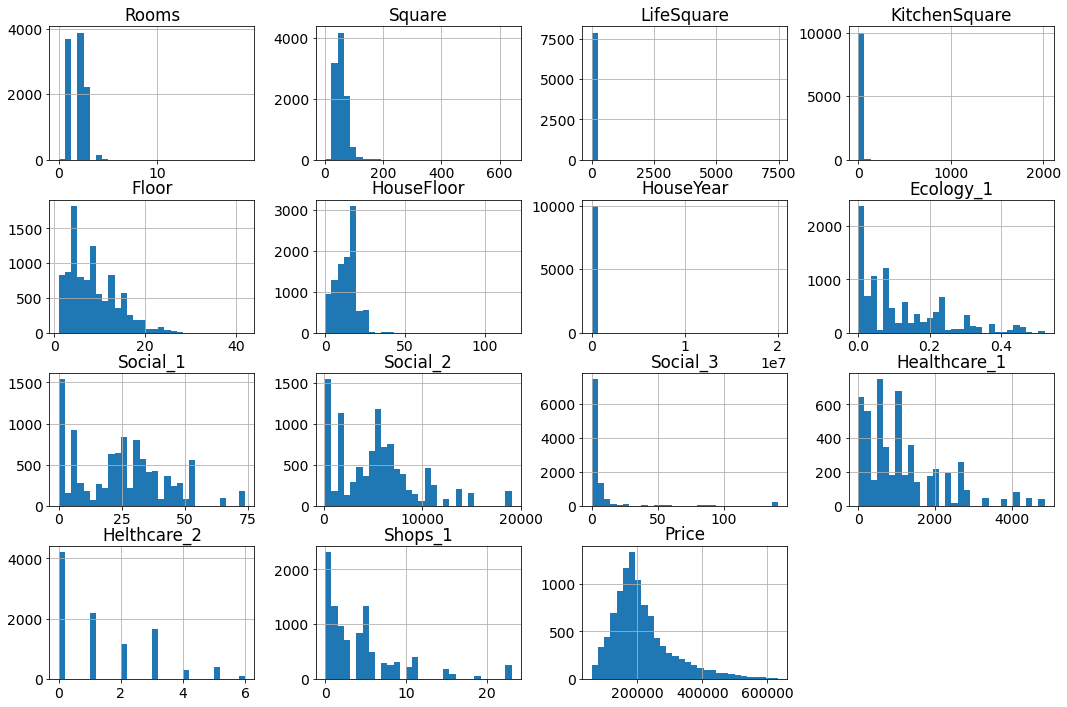

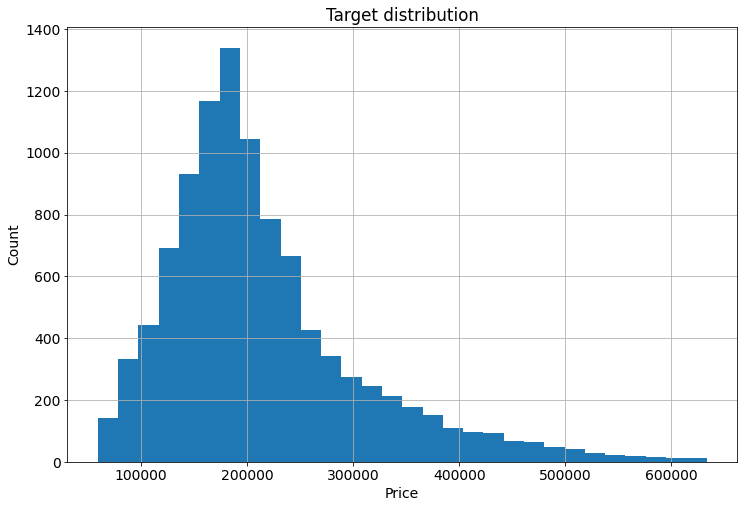

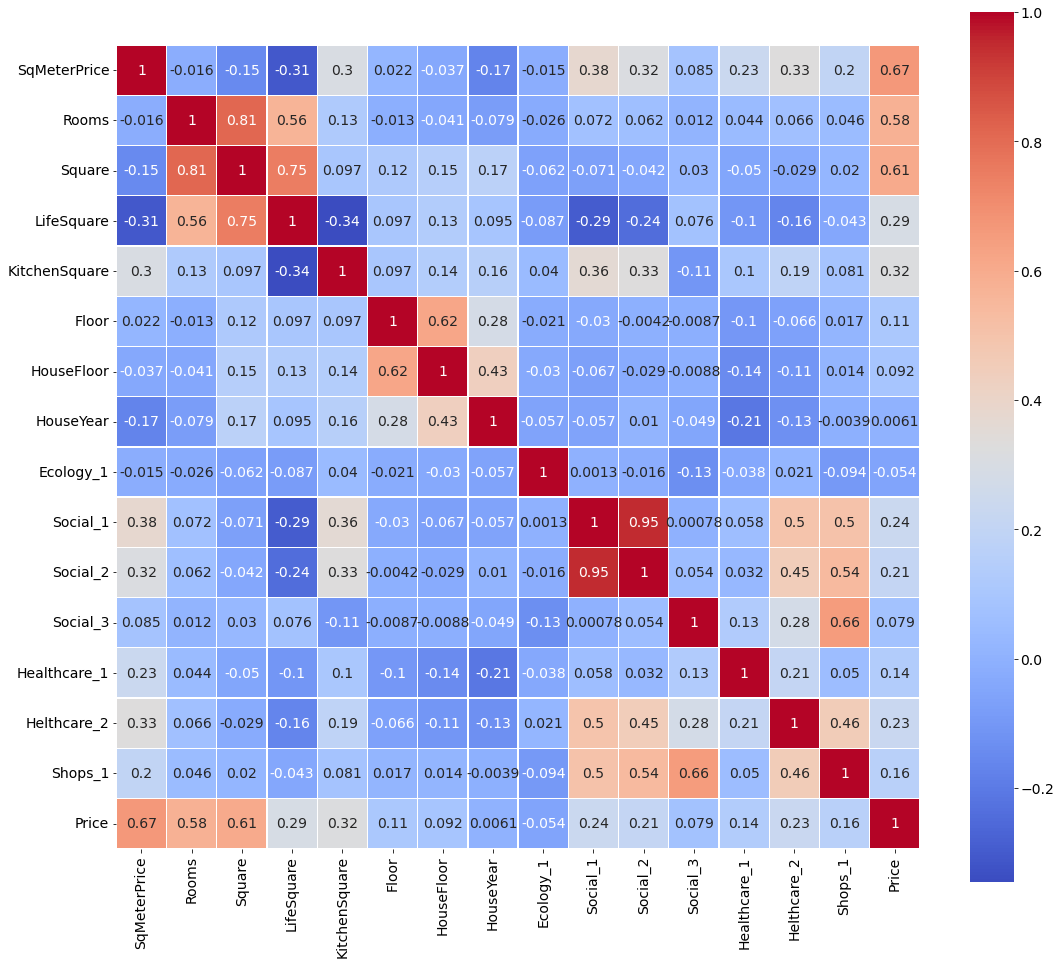

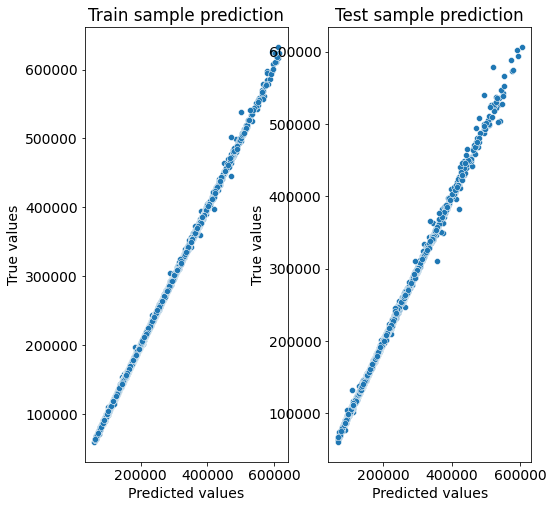

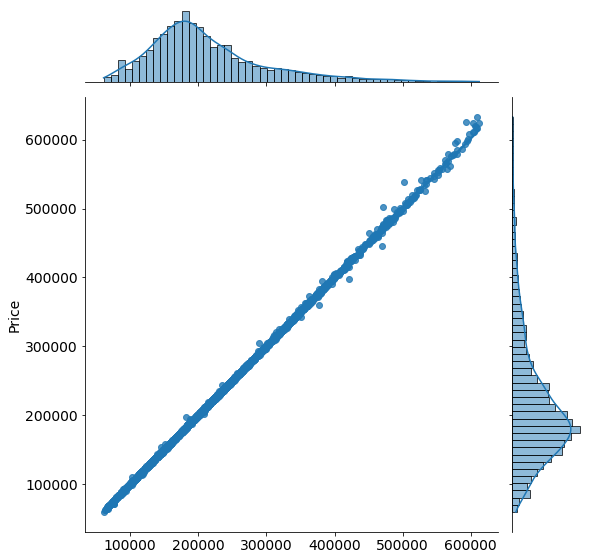

In [2]:
#Подключение библиотек и скриптов

import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

#Пути к директориям и файлам, информация о dataset

TRAIN_DATASET_PATH = './train.csv' # y_train, y_valid
TEST_DATASET_PATH = './test.csv'

train_df = pd.read_csv(TRAIN_DATASET_PATH)
print(f'чтение последних строк тренировочных данных\n {train_df.tail()}')
test_df = pd.read_csv(TEST_DATASET_PATH)
print(f'чтение последних строк тестовых данных\n {test_df.tail()}')
print(f'информация о тренировочных данных\n {train_df.info()}')
print(f'информация о тестовых данных\n {test_df.info()}')
train_df.DistrictId=train_df.DistrictId.astype('object')
train_df.Id=train_df.Id.astype('object')
print(f'информация о тренировочных данных\n {train_df.info()}')
test_df.DistrictId=test_df.DistrictId.astype('object')
test_df.Id=test_df.Id.astype('object')
print(f'информация о тестовых данных\n {test_df.info()}')
print(train_df.dtypes.value_counts())
print(test_df.dtypes.value_counts())
train_df.shape[1]-1 == test_df.shape[1]
#числовые признаки
digital_features=train_df.select_dtypes(exclude=['object'])
digital_features.hist(figsize=(18,12), bins=30)
plt.show()




plt.figure(figsize = (12, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

print(f'statistic\n {train_df.describe()}')


cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

train_df['Rooms'].value_counts()
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

print(train_df.describe())

train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.99)) &
                    (train_df['Square'] > train_df['Square'].quantile(.01))]

train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.99)) &
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.01))]

train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.99)) &
                    (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.01))]

train_df.describe()

mask = train_df["Square"] < train_df["KitchenSquare"] + train_df["LifeSquare"]
train_df.loc[mask].describe()

train_df['HouseFloor'].sort_values().unique()

train_df['Floor'].sort_values().unique()

train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index
print(len(floor_outliers))

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

train_df['HouseYear'].value_counts().sort_index()

train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020


len(train_df) - train_df.count()



print(train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10))

print(train_df['LifeSquare'].median())

square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square'] -
                   train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare'] -
                   train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

print(square_med_diff)

train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df.loc[train_df['LifeSquare'].isnull(), 'Square'] - train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare']
print(square_med_diff)
print(train_df['LifeSquare'].median())
train_df.columns.tolist()
train_df.insert(2,'SqMeterPrice', train_df.Price/train_df.Square)
print(train_df.describe())
train_df_corr=train_df.corr()
plt.figure(figsize=(18,16))
sns.heatmap(train_df_corr, annot=True, linewidths=0.3, cmap='coolwarm', square=True)
plt.show()
#цена сильно зависит от количесва комнат, площади и цены за квадратный метр
feature_names = ['Rooms', 'Square']
new_feature_names = ['SqMeterPrice']

target_name = 'Price'

print(train_df.shape)
print(test_df.shape)

# Разбиение на train и test
train_df["Rooms_vc"] = train_df["Rooms"].map(train_df["Rooms"].value_counts().to_dict())

X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

# Построение модели

X_train.isnull().sum()

rf_model = RandomForestRegressor(max_depth=12, n_estimators=500, n_jobs=-1, random_state=39)
rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

def evaluate_preds(train_values, train_pred_values, test_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_values, test_pred_values), 3)))
    plt.figure(figsize=(8,8))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)
sns.jointplot(x=y_train_preds, y=y_train, kind='reg', height=8)
plt.show()
cv_score = cross_val_score(
    rf_model,
    X.fillna(-9999),
    y, scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=21)
)
print(cv_score)
print(cv_score.mean(), cv_score.std())
print(cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std())

# Формирование файла с прогнозами
test_id = test_df["Id"]
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = np.random.randint(0, 1e6, size=test_id.shape[0])
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"
pred_df.to_csv("./KuznetcovaIS_predictions_.csv", index=False)

pred_df = pd.read_csv("./KuznetcovaIS_predictions_.csv")
print(pred_df.head(n=2))
print(pred_df.shape[0])

